In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f1341ba1890>)

In [3]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/vinyl-bin/selenium/main/naverfor_average.csv", filename="ratings_for.csv")
df = pd.read_csv("ratings_for.csv", error_bad_lines=False)
total_rating = df['star'].sum() # 판다스 구문으로 cost열을 불러 들이고 sum함수로 값을 더한다.
average_rating = round(total_rating / df['star'].count(), 2) # 평균은 count함수로 총합을 나눈다.
#data = {'filename': [filename2], 'sum': [total_rating], 'average': [average_rating]}
#all_dataFrame.append(pd.DataFrame(data=data)) # data파일을 데이터 프레임으로 만들고 리스트에 저장한다.

average_rating

/home/slim/바탕화면/senticopy/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


4.78

In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [9]:
print(total_data.isnull().values.any())

False


In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


<AxesSubplot:>

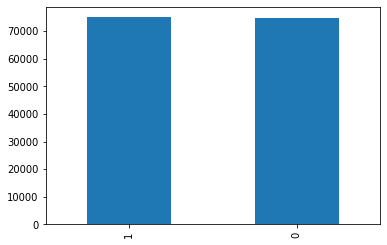

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/home/slim/바탕화면/senticopy/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [14]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/home/slim/바탕화면/senticopy/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [15]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [19]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [20]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [21]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029525614672043


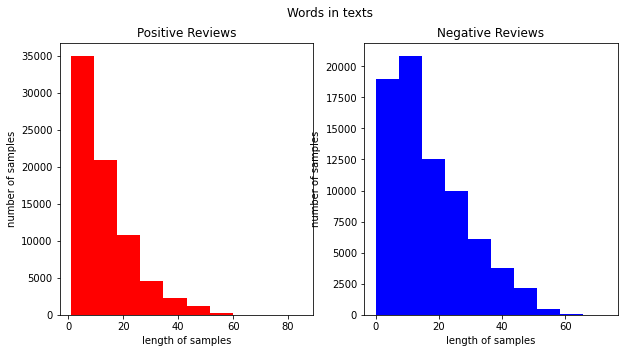

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [23]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935684918495074


In [26]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


In [27]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
print(X_train[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [29]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.30754813881052


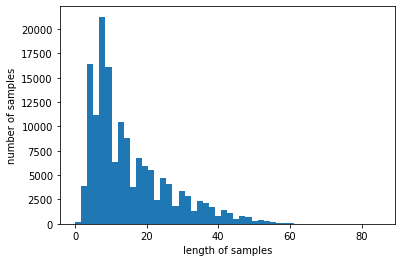

In [30]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [32]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [33]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [34]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 50

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
# model.add(LSTM(250,return_sequences=True))
# model.add(LSTM(250,return_sequences=True))
# model.add(LSTM(250,return_sequences=True))
# model.add(LSTM(250,return_sequences=True))
model.add(LSTM(250,return_sequences=True))
model.add(LSTM(250,return_sequences=True))
model.add(LSTM(250))
model.add(Dense(1))
model.add(Activation('sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

2022-07-03 12:24:21.673219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:24:21.694277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:24:21.694436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:24:21.695217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/15


2022-07-03 12:24:26.138262: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-07-03 12:24:27.193594: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1875/1875 [==============================] - ETA: 0s - loss: 0.2911 - acc: 0.8836
Epoch 1: val_acc improved from -inf to 0.91153, saving model to best_model.h5
1875/1875 [==============================] - 17s 6ms/step - loss: 0.2911 - acc: 0.8836 - val_loss: 0.2427 - val_acc: 0.9115
Epoch 2/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2316 - acc: 0.9161
Epoch 2: val_acc improved from 0.91153 to 0.92173, saving model to best_model.h5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2316 - acc: 0.9161 - val_loss: 0.2246 - val_acc: 0.9217
Epoch 3/15
1867/1875 [============================>.] - ETA: 0s - loss: 0.2175 - acc: 0.9222
Epoch 3: val_acc improved from 0.92173 to 0.92317, saving model to best_model.h5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2174 - acc: 0.9223 - val_loss: 0.2176 - val_acc: 0.9232
Epoch 4/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2103 - acc: 0.9252
Epoch 4: val_acc did not im

In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 4s 2ms/step - loss: 0.2224 - acc: 0.9236

 테스트 정확도: 0.9236


In [36]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [52]:
sentiment_predict("애기랑 사이좋게 하려고 두개 샀어요 😁방울이 엄청 많이 나와요!!!액도 좋은건지 쿠x에서 산 비눗방울 액은방울이 아예 안만들아졌었는데 ! 😡아오이건 속 시원히 아주 빵빵 많이 나오네요!!!! 👍거기다 불 때 애가 실수로 들이켜도! !이거랑 비슷하게 생긴거 과거에 샀었는데그건 애가 실수로 마시면 입안 가득 거품이였는데😰요건 그런거 1도 없어서 !!그리고 라이브 때 엄청난 행운 주셔서 감사해여❤️‍🔥넘 ㅎㅎ알라뷰 아가드👍❤️‍🔥")

1/1 [==============================] - 0s 12ms/step


7.34255388379097

In [38]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
  
    return score * 100
  else:
  
    return score * 100

In [39]:
import codecs
with codecs.open('finalsenti1.txt', 'r', encoding='utf-8', errors='ignore') as f:
    content = f.readlines()

# content = [line.rstrip('\n') for line in content]
    
print(content)

['애기랑 사이좋게 하려고 두개 샀어요 😁방울이 엄청 많이 나와요!!!액도 좋은건지 쿠x에서 산 비눗방울 액은방울이 아예 안만들아졌었는데 ! 😡아오이건 속 시원히 아주 빵빵 많이 나오네요!!!! 👍거기다 불 때 애가 실수로 들이켜도! !이거랑 비슷하게 생긴거 과거에 샀었는데그건 애가 실수로 마시면 입안 가득 거품이였는데😰요건 그런거 1도 없어서 !!그리고 라이브 때 엄청난 행운 주셔서 감사해여❤️\u200d🔥넘 ㅎㅎ알라뷰 아가드👍❤️\u200d🔥\n', '"아가 기념일 사진 셀프촬영할때마다 분위기용+포토용으로 구매했는데, 사진 촬영하면서도 예쁜 분위기 샤샤샥➰ 연출하면서 찍을 수 있어요😚\U0001f90d✨ 아가드 비눗방울 덕분에 홈스튜디오 촬영 매번 대성공👼🏻\U0001f90d💛✨✨ 촬영용 제외하고도 놀이용 또한 말모〰️ 우리 사랑둥이 아가가 아가드 비눗방울 놀이 너무 좋아해용👼🏻 선물용으로 하나 더 구매했었는데, 추가 구매 또한 계속 계속 하고 싶을 정도로 소장가치 충분해용👏🏻👏🏻💛\U0001f90d✨✨"\n', '요즘 날이 좋아서 외출하면 아기한테 비누방울 불어주고 싶어 구매했어요. 역류방지 기능이 있어 아기가 직접 불면서 놀면 더 좋겠지만 아직 어려서 엄마가 아날로그ㅎㅎ 어린시절 추억 떠올리며 마구마구 불어줬습니다ㅎㅎ 아기자기 작은 비눗방울이 엄청 풍성하게 나와서 사진 찍기 좋고👍 쉽게 터지지 않아서 더 좋은 것 같아요! 화창한 날 아가드 비눗방울로 행복한 시간 보냈어요💓\n', '"살짝만 불어줘도 비눗방울 엄청엄청 많이 나와요 거의 쏟아져나오는 수준.ᐟ.ᐟ.ᐟ역류방지설계되어있어서 비눗물 마신적 없었고, 소재도 안전하고 진짜 잘 샀어요요고 하나면 외출 인생샷 무조건 건져요👍👍👍목욕시간에 비눗방울 불어줘도 대박 좋아해요💙진짜 찐찐 만족템 남편도 맘에든다고 해죠써요👀❤️"\n', '비눗방울놀이 너무 재밌어요.....저랑 남편이 더 좋아하는 비눗방울놀이〰️✨\U0001f90d여러분 사세요 비눗방울나팔 최고예요...🙌🏻리필용액은 꼭 만들어주세요...\U0001

In [43]:
a = []    # 빈 리스트 생성
 
test = content
for i in test:
  if (sentiment_predict(str(i)) > 50):
    a.append(i)    # append로 요소 추가
 
print(a)

1/1 [==============================] - 0s 12ms/step
['"아가 기념일 사진 셀프촬영할때마다 분위기용+포토용으로 구매했는데, 사진 촬영하면서도 예쁜 분위기 샤샤샥➰ 연출하면서 찍을 수 있어요😚\U0001f90d✨ 아가드 비눗방울 덕분에 홈스튜디오 촬영 매번 대성공👼🏻\U0001f90d💛✨✨ 촬영용 제외하고도 놀이용 또한 말모〰️ 우리 사랑둥이 아가가 아가드 비눗방울 놀이 너무 좋아해용👼🏻 선물용으로 하나 더 구매했었는데, 추가 구매 또한 계속 계속 하고 싶을 정도로 소장가치 충분해용👏🏻👏🏻💛\U0001f90d✨✨"\n', '요즘 날이 좋아서 외출하면 아기한테 비누방울 불어주고 싶어 구매했어요. 역류방지 기능이 있어 아기가 직접 불면서 놀면 더 좋겠지만 아직 어려서 엄마가 아날로그ㅎㅎ 어린시절 추억 떠올리며 마구마구 불어줬습니다ㅎㅎ 아기자기 작은 비눗방울이 엄청 풍성하게 나와서 사진 찍기 좋고👍 쉽게 터지지 않아서 더 좋은 것 같아요! 화창한 날 아가드 비눗방울로 행복한 시간 보냈어요💓\n', '"살짝만 불어줘도 비눗방울 엄청엄청 많이 나와요 거의 쏟아져나오는 수준.ᐟ.ᐟ.ᐟ역류방지설계되어있어서 비눗물 마신적 없었고, 소재도 안전하고 진짜 잘 샀어요요고 하나면 외출 인생샷 무조건 건져요👍👍👍목욕시간에 비눗방울 불어줘도 대박 좋아해요💙진짜 찐찐 만족템 남편도 맘에든다고 해죠써요👀❤️"\n', '비눗방울놀이 너무 재밌어요.....저랑 남편이 더 좋아하는 비눗방울놀이〰️✨\U0001f90d여러분 사세요 비눗방울나팔 최고예요...🙌🏻리필용액은 꼭 만들어주세요...\U0001f90d 퐁퐁으로 만든 퀄리티랑 차원이 달라요...ㅋㅋㅋ오랫만에 남편이랑 재밌게 놀았어ㅇ...ㅋㅋㅋ아가드 사랑해요💛\n', '곧 15개월 아기고 역류방지기능 덕분에 아기가 직접 불어볼 수 있는 부분때문에 바로 구매했어요 내일 놀러가서 사용할건데 짜잔 하고 보여줄 생각하니 벌써 기분 좋네용^^\n', '내구성이깔끔하고좋아용비눗방울 액을 따로 더사고싶을땐어떻ㄱ하면되

In [44]:
# test = content
# for i in test:
#   if (sentiment_predict(str(i)) > 50):
#     print(i, sep='\n')

In [47]:
import pandas as pd

data = a

df = pd.DataFrame(data)
df.to_csv('good.csv', index=False)


In [50]:
b = []    # 빈 리스트 생성
 
test = content
for i in test:
  if (sentiment_predict(str(i)) <= 50):
    b.append(i)    # append로 요소 추가
 
print(b)

1/1 [==============================] - 0s 12ms/step
['애기랑 사이좋게 하려고 두개 샀어요 😁방울이 엄청 많이 나와요!!!액도 좋은건지 쿠x에서 산 비눗방울 액은방울이 아예 안만들아졌었는데 ! 😡아오이건 속 시원히 아주 빵빵 많이 나오네요!!!! 👍거기다 불 때 애가 실수로 들이켜도! !이거랑 비슷하게 생긴거 과거에 샀었는데그건 애가 실수로 마시면 입안 가득 거품이였는데😰요건 그런거 1도 없어서 !!그리고 라이브 때 엄청난 행운 주셔서 감사해여❤️\u200d🔥넘 ㅎㅎ알라뷰 아가드👍❤️\u200d🔥\n', '애기반응은 그저그래요저랑 남편만좋아하네욬ㅋㅋ작은방울이많이나오네요\n', '진짜 별루에요’ㅠㅠ 뒤로 넘어오고 조카가 사용못했습니다 ㅠ\n', '견고하고 안전해보여요. 얼른 아가랑 밖에나가 불어보고 싶네요.\n', '아무래도 입으로 불어야하니 풍성하게 나오진 않아요..ㅠㅠ\n', '아직은 어려서 잘 못해요어른들이 불어주고 있어요\n', '아..음..비눗방울이 잘 안나오네요....ㅜㅜ\n', '너무 자잘하게 나와서 좀 아쉬워요ㅠㅠ\n', '세워서해야되서 ..좀불편한감이있어요\n', '아이가 잘 불지는 못하네요 ㅠㅠ\n', '비눗방울 많이 나와요!\n', '그냥그래요..;;;\n', '생각보다 아이가 사용하기에 불편하네요...ㅠㅠ 다른 제품을 놓고 사용중이에요..ㅠㅠ액이 들어가는 공간이 너무 낮아서 금방 쏟아지고요....\n', '비누방울이 너무 자잘하게 나온다는점거품이 생기면 방울이 잘 안불어진다는점.그것빼면 그냥저냥 쓸만해요.\n', '비누방울이 너무 자잘자잘해서 아쉬웠어요\n', '방울 잘나요 ㅋㅋ 리필용액 안파나여 왜 ㅠㅠ\n', '기대 엄청 하고 구매했는데 역류하고 방울도 별로네요……조카한테 선물해줬는데 실망입니다\n', '역류해요..ㅠㅠ 아기가 혼자 하고싶대서 줬는데 역류해요ㅜㅜ\n']


In [51]:
data = b

df = pd.DataFrame(data)
df.to_csv('bad.csv', index=False)